## Preparar entorno y credenciales

### Montar drive en Colab

In [1]:
# Montar drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### GEE

In [2]:
# Instalar geemap
!pip install geemap --upgrade

import geemap
import ee
ee.Authenticate()
ee.Initialize(project="ee-freddyvillota")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.2 MB/s eta 0:00:00


## Explorar y definir área de estudio (Provincia de Carchi, Ecuador)

In [3]:
# Cargar colección de nivel 1 (provincias)
ec_provincias = ee.FeatureCollection("FAO/GAUL/2015/level1") \
    .filter(ee.Filter.eq("ADM0_NAME", "Ecuador"))

# Obtener los nombres únicos de provincias
provincias_list = ec_provincias.aggregate_array("ADM1_NAME").distinct()
print(provincias_list.getInfo())

['Napo', 'Orellana', 'Guayas', 'Pichincha', 'Santa Elena', 'Santo Domingo de los Tsachilas', 'Azuay', 'Bolivar', 'Canar', 'Carchi', 'Chimborazo', 'Cotopaxi', 'El Oro', 'Esmeraldas', 'Galapagos', 'Imbabura', 'Loja', 'Los Rios', 'Manabi', 'Morona Santiago', 'Pastaza', 'Sucumbios', 'Tungurahua', 'Zamora Chinchipe', 'Zona No Delimitada']


In [4]:
# Cargar colección de nivel 2 (cantones)
ec_cantones = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level2") \
    .filter(ee.Filter.eq("ADM0_NAME", "Ecuador")) \
    .filter(ee.Filter.eq("ADM1_NAME", "Loja"))

# Obtener los nombres únicos de cantones
cantones_list = ec_cantones.aggregate_array("ADM2_NAME").distinct()
print(cantones_list.getInfo())

['Calvas', 'Catamayo', 'Celica', 'Chaguarpamba', 'Espindola', 'Gonzanama', 'Loja', 'Macara', 'Pindal', 'Puyango', 'Quilanga', 'Saraguro', 'Sozoranga', 'Zapotillo', 'Olmedo', 'Paltas']


## Calcular PET (FAO-56) y visualizar en Earth Engine

### Análisis geoespacial en GEE

In [7]:
import ee
import geemap.foliumap as geemap

# 1) Definir el ROI de Carchi (nivel 1) de acuerdo con la exploración anterior
roi = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level1") \
    .filter(ee.Filter.eq("ADM0_NAME", "Ecuador")) \
    .filter(ee.Filter.eq("ADM1_NAME", "Carchi"))

# 2) Cargar ERA5-Land mensual para 1981 - 2024
era5 = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY") \
    .filterDate('1981-01-01', '2024-12-31') \
    .select([
        'temperature_2m',
        'dewpoint_temperature_2m',
        'u_component_of_wind_10m',
        'v_component_of_wind_10m',
        'surface_net_solar_radiation',
        'surface_net_thermal_radiation'
    ])


# 3) Definir la función para calcular la Evapotranspiración Potencial (PET)
def calcPet(img):
    # Temperaturas (°C)
    T  = img.select('temperature_2m').subtract(273.15)
    Td = img.select('dewpoint_temperature_2m').subtract(273.15)
    # Radiación neta MJ/m²·día
    Ra = img.select('surface_net_solar_radiation') \
           .add(img.select('surface_net_thermal_radiation')) \
           .divide(1e6)
    # Días en el mes
    date = img.date()
    days = ee.Image.constant(
        date.advance(1, 'month').difference(date, 'day')
    )
    Rn = Ra.divide(days)
    G = ee.Image.constant(0)
    # Saturación y pendiente (Δ)
    es = T.expression(
        '0.6108 * exp(17.27 * T / (T + 237.3))', {'T': T}
    )
    ea = Td.expression(
        '0.6108 * exp(17.27 * Td / (Td + 237.3))', {'Td': Td}
    )
    delta = es.multiply(4098).divide(T.add(237.3).pow(2))
    # Psicométrica γ
    gamma = ee.Image.constant(1.013e-3 * 101.3 / (0.622 * 2.45))
    # Velocidad del viento a 2 m
    u2m = img.select('u_component_of_wind_10m')
    v2m = img.select('v_component_of_wind_10m')
    wind_speed = u2m.pow(2).add(v2m.pow(2)).sqrt() \
        .multiply(4.87) \
        .divide(ee.Number(67.8 * 10 - 5.42).log())
    # Ecuación FAO-56
    pet = delta.multiply(Rn.subtract(G)).multiply(0.408) \
          .add(
            gamma.multiply(900).divide(T.add(273))
                 .multiply(wind_speed)
                 .multiply(es.subtract(ea))
          ) \
          .divide(
            delta.add(
              gamma.multiply(ee.Image.constant(1).add(wind_speed.multiply(0.34)))
            )
          ) \
          .rename('PET')

    return pet.copyProperties(img, img.propertyNames())



# 4) Aplicar y recortar para una fecha de interés
petCol = era5.map(calcPet)
pet_registro1 = petCol.filterDate('2020-12-01', '2020-12-31').first().clip(roi)

# 5) Calcular PET mínimo y máximo sobre el ROI
stats = pet_registro1.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=roi.geometry(),
    scale=1000,
    bestEffort=True,
    maxPixels=1e9
).getInfo()

pet_min = stats['PET_min']
pet_max = stats['PET_max']
print(f"PET mínimo = {pet_min:.3f} mm/día")
print(f"PET máximo = {pet_max:.3f} mm/día")
print(pet_registro1.date().format('YYYY-MM-dd').getInfo())


# 6) Visualizar usando los rangos dinámicos
vis = {
    'min': pet_min,
    'max': pet_max,
    'palette': ['blue', 'green', 'yellow', 'red']
}

Map = geemap.Map(center=[0.95, -78.4], zoom=8)
Map.addLayer(pet_registro1, vis, 'PET - Enero (primer mes del registro)')
Map.add_colorbar(vis_params=vis, label='PET (mm/día)')
Map.addLayer(roi.style(
    color='red',
    width=2,
    fillColor='00000000'
), {}, "Carchi - Borde rojo")
Map

PET mínimo = 0.078 mm/día
PET máximo = 0.208 mm/día
2020-12-01


### Extracción de valores de series mensuales de datos climáticos para calcular PET

Extraer de GEE los datos climáticos y calcular promedios de PET mensuales para todo el Carchi desde 1981 hasta 2024

In [8]:
import pandas as pd

# 1) Calcular PET para varios años, esta vez se aplica la función directamente a la colección de imagenes ee
era5_pet = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY") \
    .filterDate('1981-01-01', '2024-12-31') \
    .select([
        'temperature_2m', 'dewpoint_temperature_2m',
        'u_component_of_wind_10m', 'v_component_of_wind_10m',
        'surface_net_solar_radiation', 'surface_net_thermal_radiation'
    ]) \
    .map(calcPet)

# 2) Extraer promedio mensual de PET sobre el ROI
def img_to_feature(img):
    stats = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi.geometry(),
        scale=1000,
        bestEffort=True,
        maxPixels=1e9
    )
    return ee.Feature(None, stats.set('date', img.date().format('YYYY-MM')))

# 3) Convertir a lista de features
pet_features = era5_pet.map(img_to_feature).getInfo()['features']

# 4) Construir DataFrame solo con imágenes válidas
rows = []
for f in pet_features:
    props = f['properties']
    if 'PET' in props:
        rows.append({
            'date': props['date'],
            'PET_mm_day': props['PET']
        })

# 5) Crear DataFrame y procesar fechas
df_pet = pd.DataFrame(rows)
df_pet['date'] = pd.to_datetime(df_pet['date'])
df_pet = df_pet.sort_values('date').reset_index(drop=True)

# 6) Agregar año, mes y PET mensual
df_pet['year'] = df_pet['date'].dt.year
df_pet['month'] = df_pet['date'].dt.month
df_pet['PET_mm_month'] = df_pet['PET_mm_day'] * df_pet['date'].dt.days_in_month

# 7) Visualización opcional
print(df_pet.head())

        date  PET_mm_day  year  month  PET_mm_month
0 1981-01-01    0.145415  1981      1      4.507863
1 1981-02-01    0.171451  1981      2      4.800639
2 1981-03-01    0.121339  1981      3      3.761500
3 1981-04-01    0.148614  1981      4      4.458433
4 1981-05-01    0.148130  1981      5      4.592036


<ipython-input-9-14c6518e1cbd>:9: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_pet = df_pet['PET_mm_month'].resample('A').mean()


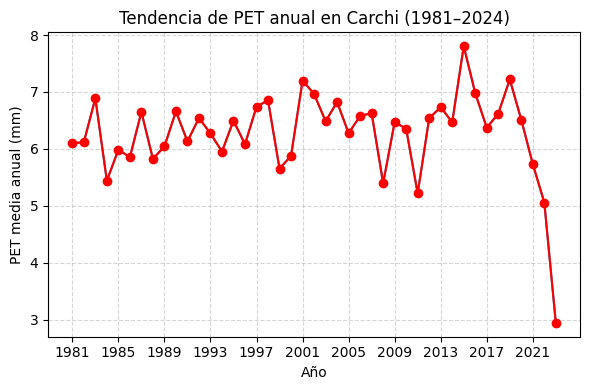

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) Preparar la columna de fecha
df_pet['date'] = pd.to_datetime(df_pet[['year', 'month']].assign(day=1))
df_pet = df_pet.set_index('date')

# 2) Calcular la PET anual como promedio de los 12 meses
annual_pet = df_pet['PET_mm_month'].resample('A').mean()
years = annual_pet.index.year

# 3) Dibujar la serie
plt.figure(figsize=(6, 4))
plt.plot(years, annual_pet.values)
plt.xlabel('Año')
plt.ylabel('PET media anual (mm)')
plt.title('Tendencia de PET anual en Carchi (1981–2024)')

# Mostrar solo cada 4 años en el eje X
step = 4
plt.xticks(years[::step])

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.plot(years, annual_pet.values, marker='o', linestyle='-', color='red')
plt.show()

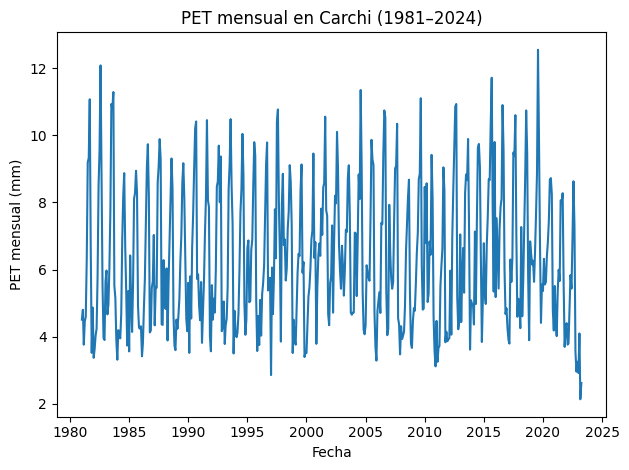

In [10]:
# Serie mensual
monthly_pet = df_pet['PET_mm_month']
plt.figure()
plt.plot(monthly_pet.index, monthly_pet.values)
plt.xlabel('Fecha')
plt.ylabel('PET mensual (mm)')
plt.title('PET mensual en Carchi (1981–2024)')
plt.tight_layout()
plt.show()

## Extraer precipitación mensual (mm) y otras variables climáticas adicionales desde Earth Engine

In [11]:
import ee
import pandas as pd

# 1) Definir ROI y período
roi = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level1") \
    .filter(ee.Filter.eq("ADM0_NAME", "Ecuador")) \
    .filter(ee.Filter.eq("ADM1_NAME", "Loja"))

era5 = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY") \
    .filterDate('1981-01-01', '2024-12-31') \
    .select([
        'total_precipitation',          # m
        'temperature_2m',               # K
        'dewpoint_temperature_2m',      # K
        'u_component_of_wind_10m',      # m/s
        'v_component_of_wind_10m',      # m/s
        'surface_net_solar_radiation',  # J/m²
        'surface_net_thermal_radiation' # J/m²
    ])

# 2) Función para convertir cada imagen en un Feature con variables climáticas.
def img_to_feature(img):
    stats = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=roi.geometry(),
        scale=10000,
        bestEffort=True,
        maxPixels=1e9
    )
    return ee.Feature(None, stats.set('date', img.date().format('YYYY-MM')))

# 3) Aplicar la función
features = era5.map(img_to_feature).getInfo()['features']

# 4) Convertir a DataFrame con validación de propiedades
rows = []
for f in features:
    props = f['properties']
    required_keys = [
        'total_precipitation', 'temperature_2m',
        'u_component_of_wind_10m', 'v_component_of_wind_10m',
        'surface_net_solar_radiation'
    ]

    if all(k in props and props[k] is not None for k in required_keys):
        rows.append({
            'date': props['date'],
            'precip_mm': float(props['total_precipitation']) * 1000,        # m → mm
            'temp_c': float(props['temperature_2m']) - 273.15,              # K → °C
            'wind_u': float(props['u_component_of_wind_10m']),
            'wind_v': float(props['v_component_of_wind_10m']),
            'solar_rad': float(props['surface_net_solar_radiation']) / 1e6 # J/m² → MJ/m²
        })

df_vars = pd.DataFrame(rows)
df_vars['date'] = pd.to_datetime(df_vars['date'])
df_vars = df_vars.sort_values('date').reset_index(drop=True)

# Resultado
df_vars.head()

,date,precip_mm,temp_c,wind_u,wind_v,solar_rad
0,1981-01-01,5.535182,17.696093,0.409728,0.060775,15.398627
1,1981-02-01,16.218946,17.690462,0.133103,0.007836,14.174679
2,1981-03-01,10.568353,17.851267,0.232666,-0.041697,14.165354
3,1981-04-01,9.812925,18.065377,0.164920,0.071957,15.215106
4,1981-05-01,3.734267,17.925042,0.004642,0.165755,15.256509


## Calcular balance hídrico mensual

In [12]:
# 1) Unir los dos DataFrames por fecha
df_balance_H = pd.merge(df_pet, df_vars, on='date')

# 2) Calcular el balance hídrico: precipitación menos PET
df_balance_H['balance_mm'] = df_balance_H['precip_mm'] - df_balance_H['PET_mm_month']

# 3) Vista previa
df_balance_H[['date', 'precip_mm', 'PET_mm_month', 'balance_mm']].head()

,date,precip_mm,PET_mm_month,balance_mm
0,1981-01-01,5.535182,4.507863,1.027319
1,1981-02-01,16.218946,4.800639,11.418307
2,1981-03-01,10.568353,3.761500,6.806853
3,1981-04-01,9.812925,4.458433,5.354492
4,1981-05-01,3.734267,4.592036,-0.857769


**Exportar a drive**

In [ ]:
# # Definir ruta y nombre del archivo
# export_path = '/content/drive/MyDrive/MIAA/Clases/Herramientas IA/Prácticas/balance_hidrico/data/era5/Carchi/df_balanceH_historico.csv'

# # Guardar como CSV
# df_balance_H.to_csv(export_path, index=False)

# print("✅ Archivo exportado correctamente a:")
# print(export_path)

### Visualización de balance hídrico en series de tiempo

<Axes: title={'center': 'Balance hídrico mensual en Carchi (mm)'}, xlabel='date'>

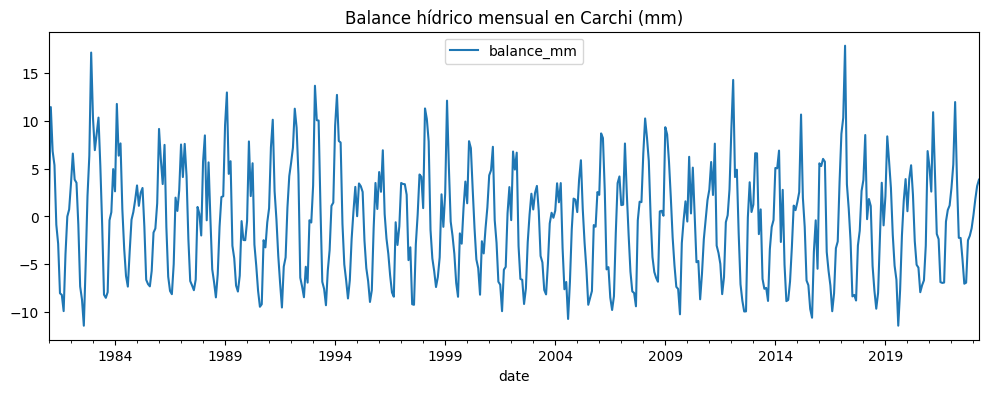

In [13]:
df_balance_H.plot(x='date', y='balance_mm', figsize=(12, 4), title='Balance hídrico mensual en Carchi (mm)')


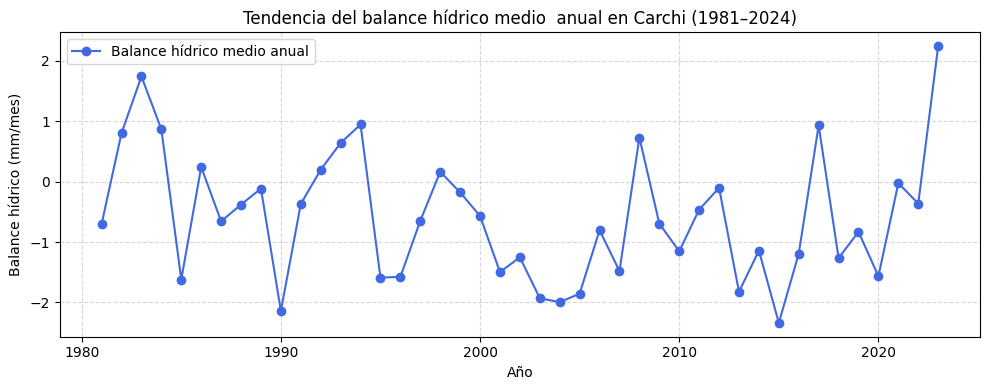

In [14]:
df_balance_H['year'] = df_balance_H['date'].dt.year

# Promedio mensual de cada año
df_annual_mean = df_balance_H.groupby('year')[['precip_mm', 'PET_mm_month', 'balance_mm']].mean().reset_index()
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(df_annual_mean['year'], df_annual_mean['balance_mm'], marker='o', linestyle='-', color='royalblue', label='Balance hídrico medio anual')

plt.xlabel('Año')
plt.ylabel('Balance hídrico (mm/mes)')
plt.title('Tendencia del balance hídrico medio  anual en Carchi (1981–2024)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.legend()
plt.show()


Desviación del balance anual respecto al promedio. Trabaja mediante el promedio de toda la serie.	¿Fue un año más seco de lo normal?

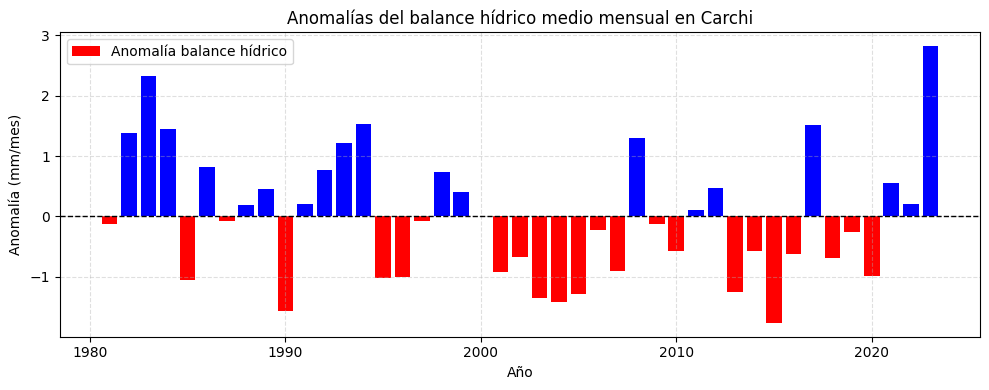

In [15]:
# Calcular la anomalía respecto a la media
balance_mean = df_annual_mean['balance_mm'].mean()
df_annual_mean['balance_anom'] = df_annual_mean['balance_mm'] - balance_mean

# Graficar anomalías
plt.figure(figsize=(10, 4))
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.bar(df_annual_mean['year'], df_annual_mean['balance_anom'],
        color=['red' if v < 0 else 'blue' for v in df_annual_mean['balance_anom']],
        label='Anomalía balance hídrico')

plt.xlabel('Año')
plt.ylabel('Anomalía (mm/mes)')
plt.title('Anomalías del balance hídrico medio mensual en Carchi')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.legend()
plt.show()



**Interpretación general**

🔵 Barras azules (anomalía positiva):
Años donde el balance hídrico fue superior al promedio histórico → hubo más agua disponible (por más lluvia, menos PET, o ambos).

🔴 Barras rojas (anomalía negativa):
Años donde el balance hídrico fue inferior al promedio histórico → hubo menos agua disponible, lo cual puede indicar condiciones secas o de estrés hídrico.

### Función para visualizar balance hídrico en GEE

In [16]:
# 1) Ver rango de fechas disponibles en la colección ERA5-Land mensual
era5_col = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY")

# Obtener primera y última imagen
first_img = era5_col.sort('system:time_start').first()
last_img = era5_col.sort('system:time_start', False).first()

# Obtener fechas
first_date = ee.Date(first_img.get('system:time_start')).format('YYYY-MM').getInfo()
last_date = ee.Date(last_img.get('system:time_start')).format('YYYY-MM').getInfo()

print(f"📅 Rango disponible en ERA5-Land mensual:")
print(f"➡️ Desde: {first_date}")
print(f"➡️ Hasta: {last_date}")

📅 Rango disponible en ERA5-Land mensual:
➡️ Desde: 1950-01
➡️ Hasta: 2023-04


In [17]:
def mostrar_balance_hidrico_con_capas(year, month, pais='Ecuador', provincia='Carchi'):
    """
    Visualiza el balance hídrico mensual (P - PET), la precipitación y la PET
    para una región administrativa usando ERA5-Land y Penman–Monteith.

    Parámetros:
    - year (int): Año (ej. 2020)
    - month (int): Mes (1–12)
    - pais (str): Nombre del país (ej. 'Ecuador')
    - provincia (str): Nombre de la provincia/estado (ej. 'Carchi')
    """
    import ee
    import geemap
    from datetime import datetime

    ee.Authenticate()
    ee.Initialize(project="ee-freddyvillota")

    # 0) Definir ROI dinámico a partir de país y provincia
    roi = ee.FeatureCollection("FAO/GAUL_SIMPLIFIED_500m/2015/level1") \
        .filter(ee.Filter.eq("ADM0_NAME", pais)) \
        .filter(ee.Filter.eq("ADM1_NAME", provincia))

    # Verificar rango disponible
    era5_col = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY")
    last_img = era5_col.sort('system:time_start', False).first()
    last_date_str = ee.Date(last_img.get('system:time_start')).format('YYYY-MM').getInfo()
    last_available = datetime.strptime(last_date_str, '%Y-%m')
    user_date = datetime(year, month, 1)

    if user_date > last_available:
        print(f"⚠️ Datos de ERA5-Land disponibles solo hasta {last_date_str}.")
        return

    # 1) Cargar ERA5 para el mes específico
    fecha_ini = f"{year}-{month:02d}-01"
    fecha_fin = f"{year}-{month:02d}-28"
    era5 = era5_col.filterDate(fecha_ini, fecha_fin)

    if era5.size().getInfo() == 0:
        print(f"⚠️ No hay datos en ERA5-Land para {year}-{month:02d}.")
        return

    # 2) Calcular PET
    petCol = era5.map(calcPet)
    pet = petCol.first()
    if pet is None:
        print(f"⚠️ No se pudo calcular la PET para {year}-{month:02d}.")
        return
    pet = pet.clip(roi).resample('bicubic')

    # 3) Precipitación
    precipCol = era5.select('total_precipitation') \
        .map(lambda img: img.multiply(1000).rename('precip_mm') \
             .copyProperties(img, img.propertyNames()))
    precip = precipCol.first()
    if precip is None:
        print(f"⚠️ No se encontró precipitación para {year}-{month:02d}.")
        return
    precip = precip.clip(roi).resample('bicubic')

    # 4) Balance
    balance = precip.subtract(pet).rename('balance_mm').clip(roi).resample('bicubic')

    # 5) Estadísticas
    stats_bal = balance.reduceRegion(ee.Reducer.minMax(), roi.geometry(), 10000).getInfo()
    stats_pet = pet.reduceRegion(ee.Reducer.minMax(), roi.geometry(), 10000).getInfo()
    stats_precip = precip.reduceRegion(ee.Reducer.minMax(), roi.geometry(), 10000).getInfo()

    # 6) Visualización
    vis_bal = {'min': stats_bal['balance_mm_min'], 'max': stats_bal['balance_mm_max'],
               'palette': ['red', 'yellow', 'green', 'blue']}
    vis_precip = {'min': stats_precip['precip_mm_min'], 'max': stats_precip['precip_mm_max'],
                  'palette': ['white', 'lightblue', 'blue', 'darkblue']}
    vis_pet = {'min': stats_pet['PET_min'], 'max': stats_pet['PET_max'],
               'palette': ['lightyellow', 'orange', 'red']}

    print(f"🟢 Visualizando {provincia} ({pais}) - {year}-{month:02d}")
    print(f"Balance hídrico (mm): {stats_bal['balance_mm_min']:.2f} – {stats_bal['balance_mm_max']:.2f}")
    print(f"Precipitación (mm): {stats_precip['precip_mm_min']:.2f} – {stats_precip['precip_mm_max']:.2f}")
    print(f"PET (mm): {stats_pet['PET_min']:.2f} – {stats_pet['PET_max']:.2f}")

    # 7) Mapa
    Map = geemap.Map()
    Map.centerObject(roi, zoom=8)
    Map.addLayer(balance, vis_bal, f'Balance {provincia} {year}-{month:02d}')
    Map.addLayer(precip, vis_precip, f'Precipitación {provincia}')
    Map.addLayer(pet, vis_pet, f'PET {provincia}')
    Map.add_colorbar(vis_params=vis_bal, label='Balance hídrico (mm)')
    Map.addLayer(roi.style(color='black', width=2, fillColor='00000000'), {}, provincia)

    return Map

In [18]:
Map = mostrar_balance_hidrico_con_capas(2022, 7, pais="Mexico", provincia="Jalisco")
Map

🟢 Visualizando Jalisco (Mexico) - 2022-07
Balance hídrico (mm): 0.43 – 17.56
Precipitación (mm): 1.30 – 17.69
PET (mm): 0.11 – 1.79


Map(center=[20.55638365214479, -103.63196188862936], controls=(WidgetControl(options=['position', 'transparent…